### Imports

In [1]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, Model
import keras as k

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

from keras.initializers import GlorotUniform

from matplotlib import pyplot as plt
import seaborn as sns
import scipy

from datetime import datetime

import pickle

from PIL import Image

from custom_class import *

print(f"pd.__version__: {pd.__version__}")
print(f"tf.__version__: {tf.__version__}")

pd.__version__: 2.2.3
tf.__version__: 2.17.1


### Read file path and labels to list

In [2]:
dataset_dir = "/kaggle/working/Dataset/machine-learning-in-science-ii-2025"
# dataset_dir = "/kaggle/input/machine-learning-in-science-ii-2025"

csv_path = os.path.join(dataset_dir, "training_norm.csv")
csv_df = pd.read_csv(csv_path, index_col="image_id")

training_data_dir = os.path.join(dataset_dir, "training_data", "training_data")

# there is one speed > 1. So change it.
csv_df.loc[csv_df["speed"] > 1, "speed"] = 1

csv_df.drop(columns=["speed"], inplace=True)

display(csv_df)

,angle
image_id,
1,0.4375
2,0.8125
3,0.4375
4,0.6250
5,0.5000
...,...
13794,0.6250
13795,0.4375
13796,0.5625


Check the data

(array([  88.,  197.,  104.,  641., 1467., 3655., 3970., 2123., 1448.,
         100.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

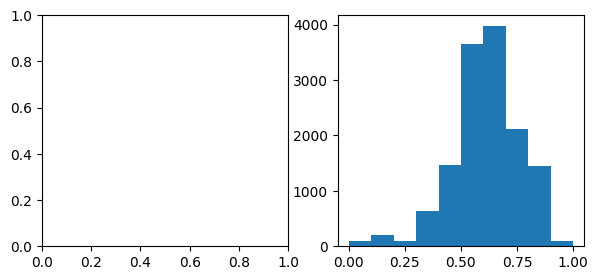

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
ax[1].hist(csv_df["angle"])

0.00000 60
0.06250 28
0.12500 99
0.18750 98
0.25000 104
0.31250 213
0.37500 428
0.43750 1467
0.50000 2046
0.56250 1609
0.62500 1963
0.68750 2007
0.75000 2123
0.81250 1147
0.87500 301
0.93750 65
1.00000 35
{0.0: 60, 0.0625: 28, 0.125: 99, 0.1875: 98, 0.25: 104, 0.3125: 213, 0.375: 428, 0.4375: 1467, 0.5: 2046, 0.5625: 1609, 0.625: 1963, 0.6875: 2007, 0.75: 2123, 0.8125: 1147, 0.875: 301, 0.9375: 65, 1.0: 35}


<BarContainer object of 17 artists>

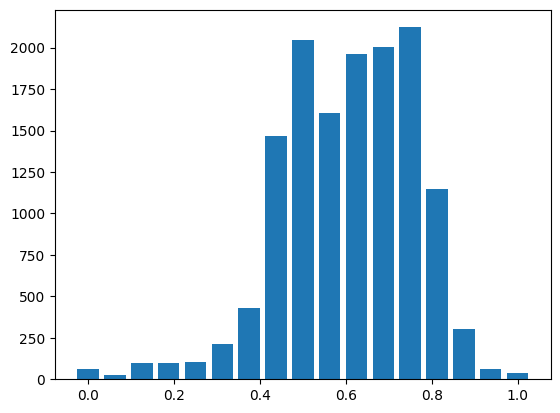

In [4]:
angle = csv_df["angle"]

df = pd.DataFrame(angle)
bins = np.unique(angle)
c = df["angle"].value_counts()

angle_count = {}

for bin in bins:
    angle_count[bin] = c[bin]

key, value = list(angle_count.keys()), list(angle_count.values())

for i in range(len(key)):
    print(f"{key[i]:.5f} {value[i]}")

print(angle_count)

plt.bar(key, value, width=0.05)

In [5]:
# for rs in range(10000):
#     X = np.array(csv_df.index)
#     y = np.array(csv_df['angle'])
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=rs)
#     X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=(0.15/0.85), random_state=rs)

#     # print(X_train.shape)
#     # print(X_val.shape)
#     # print(X_test.shape)
#     # print(X.shape)

#     train_count = pd.Series(y_train).value_counts()
#     train_count = train_count / sum(train_count) * 100
#     # val_count = pd.Series(y_val).value_counts()
#     # val_count = val_count / sum(val_count) * 100
#     # test_count = pd.Series(y_test).value_counts()
#     # test_count = test_count / sum(test_count) * 100

#     ori_count = pd.Series(y).value_counts()
#     ori_count = ori_count / sum(ori_count) * 100

#     diff = (sum(abs(train_count-ori_count)))

#     if (diff < 0.6):
#         print(f"random state: {rs}")
#         print(diff)

#     bar_width = 0.015
#     # plt.bar(val_count.index-bar_width, train_count, width=bar_width)
#     # plt.bar(train_count.index, train_count, width=bar_width)
#     # plt.bar(ori_count.index+bar_width, train_count, width=bar_width)
#     # plt.bar(test_count.index+bar_width, train_count, width=bar_width)

random state: 5695
0.4295065874309431


<BarContainer object of 17 artists>

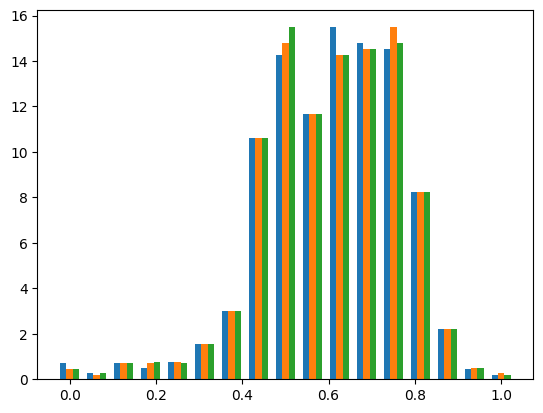

In [6]:
rs = 5695
X = np.array(csv_df.index)
y = np.array(csv_df["angle"])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=rs
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=(0.15 / 0.85), random_state=rs
)

train_count = pd.Series(y_train).value_counts()
train_count = train_count / sum(train_count) * 100
val_count = pd.Series(y_val).value_counts()
val_count = val_count / sum(val_count) * 100
test_count = pd.Series(y_test).value_counts()
test_count = test_count / sum(test_count) * 100

ori_count = pd.Series(y).value_counts()
ori_count = ori_count / sum(ori_count) * 100

diff = sum(abs(train_count - ori_count))

if diff < 0.7:
    print(f"random state: {rs}")
    print(diff)

bar_width = 0.015
plt.bar(val_count.index - bar_width, train_count, width=bar_width)
plt.bar(train_count.index, train_count, width=bar_width)
# plt.bar(ori_count.index+bar_width, train_count, width=bar_width)
plt.bar(test_count.index + bar_width, train_count, width=bar_width)

In [7]:
train_count = pd.Series(y_train).value_counts().sort_index()
train_total = np.sum(train_count)

weight = train_total / (len(train_count) * train_count)
weight = weight / min(weight)

lower, upper = (0, 1)
weight = weight.apply(lambda x: x if x < upper else upper)
weight = weight.apply(lambda x: x if x > lower else lower)


p_for_random_choice = weight[y_train].values

p_for_random_choice = p_for_random_choice / sum(p_for_random_choice)

print(weight)

0.0000    1
0.0625    1
0.1250    1
0.1875    1
0.2500    1
0.3125    1
0.3750    1
0.4375    1
0.5000    1
0.5625    1
0.6250    1
0.6875    1
0.7500    1
0.8125    1
0.8750    1
0.9375    1
1.0000    1
Name: count, dtype: int64


In [8]:
# # Define generator for weighted sampling
# def sample_generator(X, y, sample_probs):
#     idx = np.random.choice(len(y), p=sample_probs)  # Sample index
#     return X[idx], y[idx]


# X_train_os = []
# y_train_os = []

# for i in range(10240):
#     X_sampled, y_sampled = sample_generator(X_train, y_train, p_for_random_choice)
#     X_train_os.append(X_sampled)
#     y_train_os.append(y_sampled)

# # for i in range(10):
# #     print(X_train_os[i], y_train_os[i])
# #     print(csv_df.loc[X_train_os[i]]['angle'])

# # print(pd.Series(y_train).value_counts().sort_index())

# # print(pd.Series(y_train_os).value_counts().sort_index())

# y_train_os_count = pd.Series(y_train_os).value_counts().sort_index()

# plt.bar(list(y_train_os_count.index), y_train_os_count, width=0.04)
# plt.title("Over sampled")

In [9]:
sample_probs_tensor = tf.constant(p_for_random_choice, dtype=tf.float32)

X_train_tensor = tf.constant(X_train, dtype=tf.int32)
y_train_tensor = tf.constant(y_train, dtype=tf.float32)

NUM_SAMPLES = 32*400

def sample_indices():
    return tf.random.categorical(tf.math.log([sample_probs_tensor]), NUM_SAMPLES)[0]

sampled_indices = sample_indices()

X_train_os = tf.gather(X_train_tensor, sampled_indices)
y_train_os = tf.gather(y_train_tensor, sampled_indices)

train_ds = tf.data.Dataset.from_tensor_slices((X_train_os, y_train_os))

In [10]:
ids = []
angles = []
for id, angle in train_ds:
    ids.append(id.numpy())
    angles.append(angle.numpy())

Text(0.5, 1.0, 'Distribution of angles after oversampling')

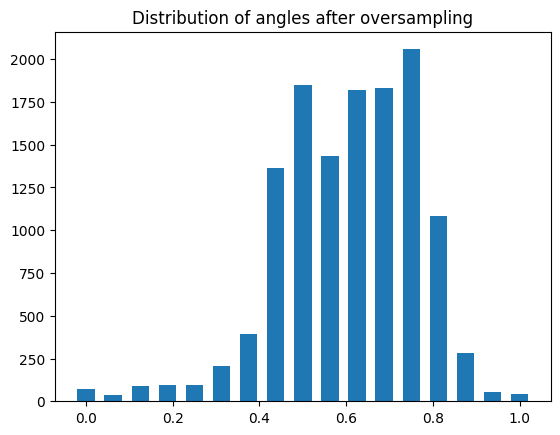

In [11]:
y_count = pd.Series(angles).value_counts().sort_index()
plt.bar(y_count.index, y_count, width=0.04)
plt.title("Distribution of angles after oversampling")

In [12]:
# X_train_os_path = [
#     os.path.join(training_data_dir, str(image_id) + ".png") for image_id in X_train_os
# ]
X_val_path = [
    os.path.join(training_data_dir, str(image_id) + ".png") for image_id in X_val
]

In [13]:
def decode_img(
    img,
):  # -> Any | defaultdict | Any | list | None | object | Tensor | ...:
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def process_path(file_path, angle):
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, angle

def image_id_to_path(image_id, angle):
    image_path = tf.strings.join([training_data_dir, '/', tf.as_string(image_id), ".png"])  # Assuming images are .jpg
    return image_path, angle

In [14]:
# train_ds = tf.data.Dataset.from_tensor_slices((X_train_os_path, y_train_os))
train_ds = tf.data.Dataset.from_tensor_slices((X_train_os, y_train_os))
train_ds = train_ds.map(image_id_to_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val_path, y_val))

train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

train_ds_length = tf.data.experimental.cardinality(train_ds).numpy()
print(train_ds_length)
val_ds_length = tf.data.experimental.cardinality(val_ds).numpy()
print(val_ds_length)

12800
2069


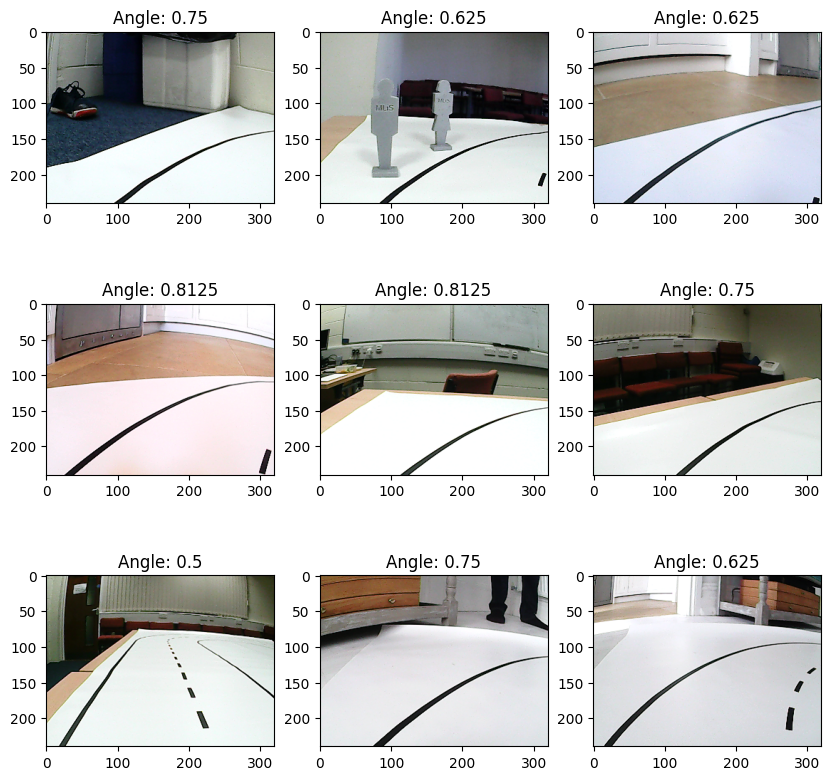

In [15]:
plt.figure(figsize=(10, 10))
i = 0

for image, angle in train_ds.take(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("float32"))
    angle = angle.numpy()
    plt.title(f"Angle: {angle}")
    i += 1

In [16]:
def visualise(original, augmented):
    fig = plt.figure()
    plt.subplot(1, 2, 1)
    plt.title("Original image")
    plt.imshow(original.numpy().astype("float32"))

    plt.subplot(1, 2, 2)
    plt.title("Augmented image")
    plt.imshow(augmented.numpy().astype("float32"))

In [17]:
rotate_by_degree = 5
random_rotate = keras.layers.RandomRotation(rotate_by_degree / 360)


def augment(image, angle, seed=None):
    # Deal with the random seed
    if seed == None:
        seed = tf.random.uniform(shape=[2], maxval=10000, dtype=tf.int32)
    else:
        seed = tf.constant([seed, seed], dtype=tf.int32)

    image = tf.image.stateless_random_brightness(image, 0.3, seed)
    image = tf.image.stateless_random_contrast(image, 0.75, 1.25, seed)
    image = tf.image.stateless_random_hue(image, 0.05, seed)
    image = tf.image.stateless_random_saturation(image, 0.7, 1.2, seed)

    image = random_rotate(image)

    # crop image
    image = tf.image.stateless_random_crop(image, size=[210, 280, 3], seed=seed)

    # resize image back to 240x320
    image = tf.image.resize(image, [240, 320])

    return image, angle

Test augment function

20
Augmented image shape: (240, 320, 3)


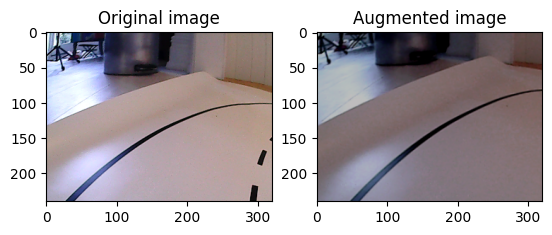

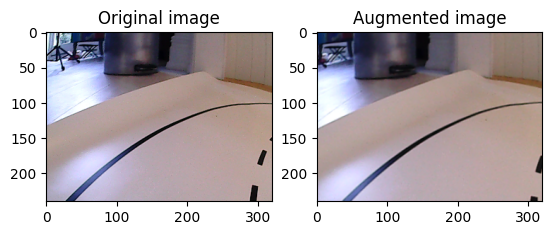

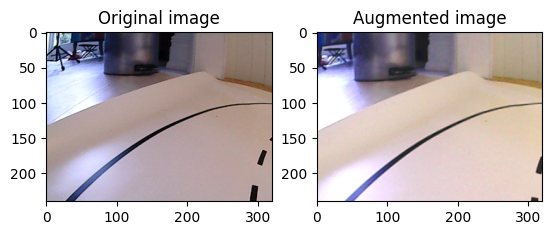

In [18]:
skip = 20
# skip+=1
print(skip)
for i in range(3):
    for image, angle in train_ds.skip(skip).take(1):
        augmented_image, angle = augment(image, angle, None)
        visualise(image, augmented_image)

for image, angle in train_ds.take(1):
    aug_image, aug_angle = augment(image, angle)
    print(f"Augmented image shape: {aug_image.shape}")

In [19]:
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

In [20]:
def rephrase_ds(image, angle):
    return image, {"angle_output": angle}


train_ds = train_ds.map(rephrase_ds, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(rephrase_ds, num_parallel_calls=tf.data.AUTOTUNE)

In [21]:
batch_size = 64


def configure_for_performance(ds, shuffle: bool, batch: bool):
    if shuffle:
        ds = ds.shuffle(buffer_size=5000)
    if batch:
        ds = ds.batch(batch_size, drop_remainder=True)
    else:
        ds = ds.batch(1, drop_remainder=False)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds


train_ds = train_ds.repeat()
val_ds = val_ds.repeat()
train_ds = configure_for_performance(train_ds, shuffle=True, batch=True)
val_ds = configure_for_performance(val_ds, shuffle=False, batch=True)

### Build model

In [22]:
image_shape = (240, 320, 3)

base_model = keras.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=image_shape,
    pooling=None,
    name="efficientnetv2-s",
)
base_model.trainable = False

In [23]:
feature_extractor = base_model.output

print(feature_extractor.shape)

# angle

angle_conv_features = layers.Conv2D(
    filters=128, kernel_size=(3, 3), padding='same', activation='relu', 
    kernel_initializer='he_uniform', name='angle_conv1'
)(feature_extractor)

angle_conv_features = layers.BatchNormalization(name='angle_conv1_bn')(angle_conv_features)

angle_conv_features = layers.Conv2D(
    filters=64, kernel_size=(3, 3), padding='same', activation='relu', 
    kernel_initializer='he_uniform', name='angle_conv2'
)(angle_conv_features)

angle_conv_features = layers.BatchNormalization(name='angle_conv2_bn')(angle_conv_features)

angle_flat_features = layers.Flatten(name='angle_flatten')(angle_conv_features)

print(angle_flat_features.shape)

angle_hidden3 = layers.Dense(2048, activation="relu", kernel_initializer="he_uniform", name="angle_hidden3")(angle_flat_features)
angle_hidden3 = layers.Dropout(0.3, name='angle_hidden3_dropout')(angle_hidden3)
angle_hidden2 = layers.Dense(1280, activation="relu", kernel_initializer="he_uniform", name="angle_hidden2")(angle_hidden3)
angle_hidden2 = layers.Dropout(0.3, name='angle_hidden2_dropout')(angle_hidden2)
angle_hidden = layers.Dense(128, activation="relu", kernel_initializer="he_uniform", name="angle_hidden")(angle_hidden2)
angle_output = layers.Dense(1, activation="linear", name="angle_output")(angle_hidden)

model = Model(inputs=base_model.input, outputs=[angle_output], name="my_model")

learning_rate = 0.0006

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss={"angle_output": "mse"},
    metrics={"angle_output": ["mae"]},
)

# model.summary()

(None, 8, 10, 1280)
(None, 5120)


In [24]:
sub_model = Model(
    inputs=feature_extractor, outputs=[angle_output], name="ensemble_head"
)

tf.keras.utils.plot_model(
    sub_model,
    show_shapes=True,  # Show input/output shapes
    show_layer_names=True,  # Show layer names (e.g., "angle_hidden_2")
    expand_nested=False,  # Keep it flat (no base_model nesting)
    show_layer_activations=True,
    dpi=96,  # Image resolution
)

print("Saved model image: model.png")

Saved model image: model.png


In [25]:
def lr_schedule(epoch, lr):
    initial_lr = learning_rate
    if epoch == 0:
        return 0.002
        return initial_lr * 2
    decay = 0.3
    return initial_lr / (1 + ((epoch-1) // 2) * decay)

for epoch in range(30):
    print(f"Epoch {epoch+1:2d}: {lr_schedule(epoch, 0):.6f}")

Epoch  1: 0.002000
Epoch  2: 0.000600
Epoch  3: 0.000600
Epoch  4: 0.000462
Epoch  5: 0.000462
Epoch  6: 0.000375
Epoch  7: 0.000375
Epoch  8: 0.000316
Epoch  9: 0.000316
Epoch 10: 0.000273
Epoch 11: 0.000273
Epoch 12: 0.000240
Epoch 13: 0.000240
Epoch 14: 0.000214
Epoch 15: 0.000214
Epoch 16: 0.000194
Epoch 17: 0.000194
Epoch 18: 0.000176
Epoch 19: 0.000176
Epoch 20: 0.000162
Epoch 21: 0.000162
Epoch 22: 0.000150
Epoch 23: 0.000150
Epoch 24: 0.000140
Epoch 25: 0.000140
Epoch 26: 0.000130
Epoch 27: 0.000130
Epoch 28: 0.000122
Epoch 29: 0.000122
Epoch 30: 0.000115


In [26]:
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath="checkpoints/model_epoch_{epoch:02d}.keras",
    save_weights_only=False,
    save_freq="epoch",
    verbose=1,
)

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)

history_callback = keras.callbacks.History()

try:
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=30,
        steps_per_epoch= train_ds_length // batch_size,
        validation_steps= val_ds_length // batch_size,
        callbacks=[checkpoint, history_callback, lr_scheduler],
        verbose=1,
    )
except KeyboardInterrupt:
    print("Stopped early—saving history")
    with open("training_history.pkl", "wb") as f:
        pickle.dump(history_callback.history, f)


Epoch 1: LearningRateScheduler setting learning rate to 0.002.
Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - loss: 100.6065 - mae: 1.8954
Epoch 1: saving model to checkpoints/model_epoch_01.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 109s 289ms/step - loss: 100.2088 - mae: 1.8884 - val_loss: 0.0281 - val_mae: 0.1402 - learning_rate: 0.0020

Epoch 2: LearningRateScheduler setting learning rate to 0.0006.
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - loss: 0.0203 - mae: 0.1035
Epoch 2: saving model to checkpoints/model_epoch_02.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 49s 245ms/step - loss: 0.0203 - mae: 0.1035 - val_loss: 0.0151 - val_mae: 0.0907 - learning_rate: 6.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0006.
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - loss: 0.0184 - mae: 0.0995
Epoch 3: saving model to checkpoints/model_epoch_03.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 48s 242ms/step - loss: 0.0184 - mae: 0.0995 - val_loss: 0.0187 - val_mae: 0.1

In [27]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")  # Format: YYYYMMDD_HHMM
name_template = f'v2_angle_model_{timestamp}'

folder_path = f"Models/{name_template}"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

filename = f"{folder_path}/{name_template}.keras"
model.save(filename)
filename = f"{folder_path}/{name_template}.weights.h5"
model.save_weights(filename)

history = history_callback.history

filename = f"{folder_path}/{name_template}_history.pkl"
with open(filename, 'wb') as f:
    pickle.dump(history, f)

['loss', 'mae', 'val_loss', 'val_mae']


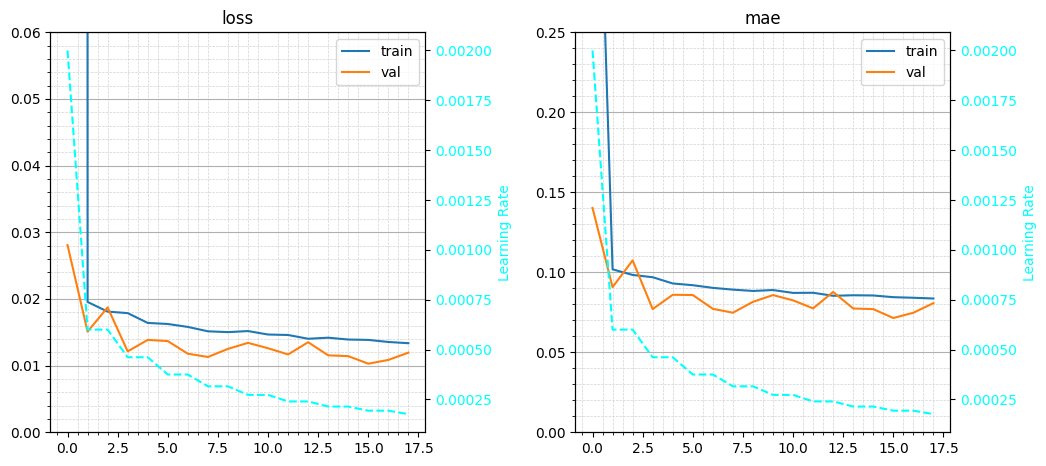

In [28]:
history = history_callback.history
history_1 = history_callback.history

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plt.subplots_adjust(left=0.1, right=0.85, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)


ax = ax.ravel()

keys = list(history.keys())
print(keys)
needed = [0, 1]
groups = [keys[i] for i in needed]

for key in history.keys():
    for j in range(len(groups)):
        if key.endswith(groups[j]):
            label = "val" if key.startswith("val") else "train"
            ax[j].plot(history[key], label=label)
            ax[j].set_title(groups[j])
            ax[j].minorticks_on()
            ax[j].grid(True, axis="y")
            ax[j].grid(which='minor', linestyle='--', linewidth=0.5, color='lightgray')
            ax[j].legend()
            break

ylim_list = [
    (0, 0.06),
    (0, 0.25),
]
for i in range(len(groups)):
    # l, u = ylim_list[i]
    ax[i].set_ylim(ylim_list[i])

learning_rates = [lr_schedule(epoch, 1) for epoch in range(len(history['loss']))]

for i in range(len(groups)):
    ax_lr = ax[i].twinx()
    ax_lr.plot(learning_rates, color="cyan", label="Learning Rate", linestyle="--")
    ax_lr.set_ylabel("Learning Rate", color="cyan")
    ax_lr.tick_params(axis="y", labelcolor="cyan")

# ax[1].text(20 ,0,f"OverSampling max {upper}, v2S", rotation=90, ha='center')

# model_details_text = [
#     f"Model details: Batch {batch_size}, LR: {learning_rate}",
#     "EfficientNetV2S",
#     "two paths: ",
#     "GlobalAveragePooling2D+norm+dropout and ",
#     "conv2D(128,(3,3)) -> norm -> flatten",
#     "merge -> norm -> dense(2560) -> dropout",
#     "Split to two 1024 (relu), 512 (relu), 100 (relu), 1",
# ]

# ax[-1].axis("off")
# ax[-2].axis("off")
# ax[-3].axis("off")
# for i in range(len(model_details_text)):
#     ax[-3].text(x=0.5, y=0.9 - i * 0.09, s=model_details_text[i])



plt.savefig(f"{folder_path}/{name_template}.png")

In [ ]:
# for layer in base_model.layers[-20:]:  # Freeze all but the last 20 layers
#     layer.trainable = True

# learning_rate = 0.002

# model.compile(
#     optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
#     loss={"angle_output": "mse"},
#     metrics={"angle_output": ["mae"]},
# )

# def lr_schedule(epoch, lr):
#     initial_lr = learning_rate
#     epoch += 7
#     if epoch == 0:
#         return initial_lr * 2
#     decay = 0.3
#     return initial_lr / (1 + ((epoch) // 3) * decay)

# for epoch in range(30):
#     print(f"Epoch {epoch+11:2d}: {lr_schedule(epoch, 0):.6f}")

# checkpoint = keras.callbacks.ModelCheckpoint(
#     filepath="checkpoints/model_epoch_{epoch:02d}.keras",
#     save_weights_only=False,
#     save_freq="epoch",
#     verbose=1,
# )

# lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)

# history_callback = keras.callbacks.History()



In [ ]:
# try:
#     history = model.fit(
#         train_ds,
#         validation_data=val_ds,
#         epochs=10,
#         steps_per_epoch= train_ds_length // batch_size,
#         validation_steps= val_ds_length // batch_size,
#         callbacks=[checkpoint, history_callback, lr_scheduler],
#         verbose=1,
#     )
# except KeyboardInterrupt:
#     print("Stopped early—saving history")
#     with open("training_history.pkl", "wb") as f:
#         pickle.dump(history_callback.history, f)

In [ ]:
# name_template = f'v2_angle_model_unfreezed_{timestamp}'

# folder_path = f"Models/{name_template}"

# if not os.path.exists(folder_path):
#     os.makedirs(folder_path)

# filename = f"{folder_path}/{name_template}.keras"
# model.save(filename)
# filename = f"{folder_path}/{name_template}.weights.h5"
# model.save_weights(filename)

# history = history_callback.history

# filename = f"{folder_path}/{name_template}_history.pkl"
# with open(filename, 'wb') as f:
#     pickle.dump(history, f)

In [ ]:
# history_2 = history_callback.history

# history = {}

# # Merge using numpy.concatenate
# for key in history_1.keys():
#     history[key] = np.concatenate([history_1[key], history_2[key]])

# fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# plt.subplots_adjust(left=0.1, right=0.85, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)


# ax = ax.ravel()

# keys = list(history.keys())
# print(keys)
# needed = [0, 1]
# groups = [keys[i] for i in needed]

# for key in history.keys():
#     for j in range(len(groups)):
#         if key.endswith(groups[j]):
#             label = "val" if key.startswith("val") else "train"
#             ax[j].plot(history[key], label=label)
#             ax[j].set_title(groups[j])
#             ax[j].minorticks_on()
#             ax[j].grid(True, axis="y")
#             ax[j].grid(which='minor', linestyle='--', linewidth=0.5, color='lightgray')
#             ax[j].legend()
#             break

# ylim_list = [
#     (0, 0.06),
#     (0, 0.25),
# ]
# for i in range(len(groups)):
#     # l, u = ylim_list[i]
#     ax[i].set_ylim(ylim_list[i])

# learning_rates = [lr_schedule(epoch, 1) for epoch in range(len(history['loss']))]

# for i in range(len(groups)):
#     ax_lr = ax[i].twinx()
#     ax_lr.plot(learning_rates, color="cyan", label="Learning Rate", linestyle="--")
#     ax_lr.set_ylabel("Learning Rate", color="cyan")
#     ax_lr.tick_params(axis="y", labelcolor="cyan")

# ax[1].text(13 ,0,f"OverSampling max {upper}, v2M", rotation=90, ha='center')

# # model_details_text = [
# #     f"Model details: Batch {batch_size}, LR: {learning_rate}",
# #     "EfficientNetV2S",
# #     "two paths: ",
# #     "GlobalAveragePooling2D+norm+dropout and ",
# #     "conv2D(128,(3,3)) -> norm -> flatten",
# #     "merge -> norm -> dense(2560) -> dropout",
# #     "Split to two 1024 (relu), 512 (relu), 100 (relu), 1",
# # ]

# # ax[-1].axis("off")
# # ax[-2].axis("off")
# # ax[-3].axis("off")
# # for i in range(len(model_details_text)):
# #     ax[-3].text(x=0.5, y=0.9 - i * 0.09, s=model_details_text[i])



# plt.savefig(f"{folder_path}/{name_template}.png")